# Earthquake_real
> Non-Euclidean geometry

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import folium

In [3]:
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

- t = Year
- x = Latitude
- y = Longitude
- f = Magnitude

##### 1. 데이터 정의

In [4]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2000"').reset_index().iloc[:,1:]
_df

,Date,Latitude,Longitude,Magnitude,Year
0,01/01/2000,-60.7220,153.6700,6.0,2000
1,01/02/2000,-17.9430,-178.4760,5.5,2000
2,01/02/2000,51.4470,-175.5580,5.8,2000
3,01/02/2000,-20.7710,-174.2360,5.8,2000
4,01/05/2000,-20.9640,-174.0970,5.6,2000
...,...,...,...,...,...
8739,12/28/2016,38.3917,-118.8941,5.6,2016
8740,12/28/2016,38.3777,-118.8957,5.5,2016
8741,12/28/2016,36.9179,140.4262,5.9,2016
8742,12/29/2016,-9.0283,118.6639,6.3,2016


In [6]:
__df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2015"').reset_index().iloc[:,1:]
__df

,Date,Latitude,Longitude,Magnitude,Year
0,01/02/2015,6.5739,60.3653,5.5,2015
1,01/05/2015,-43.0546,171.2364,5.6,2015
2,01/06/2015,55.2049,163.2446,5.6,2015
3,01/07/2015,5.9045,-82.6576,6.5,2015
4,01/08/2015,-61.6118,161.3346,5.7,2015
...,...,...,...,...,...
910,12/28/2016,38.3917,-118.8941,5.6,2016
911,12/28/2016,38.3777,-118.8957,5.5,2016
912,12/28/2016,36.9179,140.4262,5.9,2016
913,12/29/2016,-9.0283,118.6639,6.3,2016


##### 2. $f(x) = y + \epsilon$ 정의
- $y$ = Magnitude,  지진 규모로 정의

In [7]:
f_true = _df.loc[:,"Magnitude"]

In [8]:
f = f_true + np.random.normal(scale=0.2,size=len(f_true))

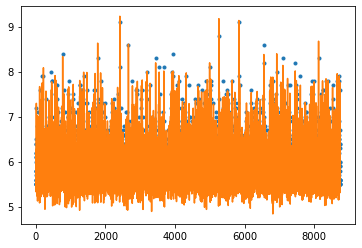

In [9]:
plt.plot(f_true,'.')
plt.plot(f,'-')

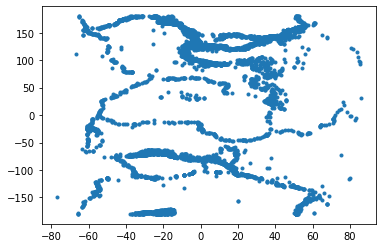

In [10]:
plt.plot( _df.Latitude,_df.Longitude,'.')

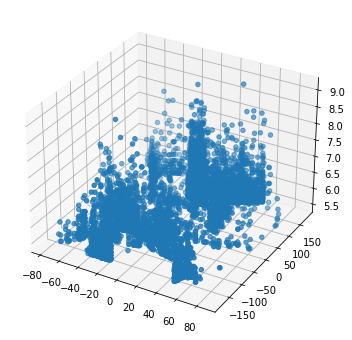

In [11]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(_df.Latitude, _df.Longitude, _df.Magnitude)
#ax.scatter(_df.Latitude, _df.Longitude, 0)

In [12]:
from mpl_toolkits.basemap import Basemap

In [13]:
#collapse

from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

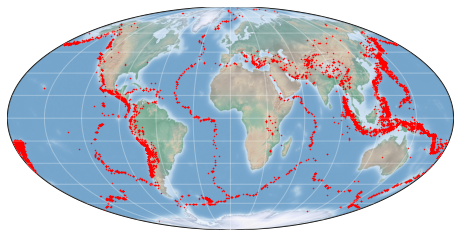

In [14]:
#collapse

fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='moll', resolution=None,
            lat_0=0, lon_0=0)
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
m.plot(x, y, 'r.', markersize=1)
draw_map(m)

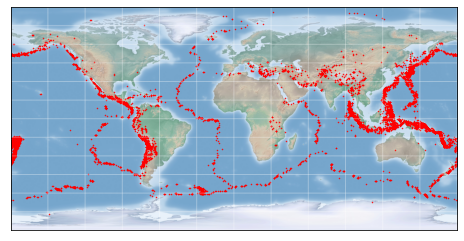

In [15]:
#collapse

fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
m.plot(x, y, 'r.', markersize=1)
draw_map(m)

In [16]:
#collapse
lst=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2016-2000)]

In [17]:
#collapse
from folium import plugins 
data=(np.random.normal(size=(100,3)) + np.array([[28,77,5]])).tolist() # (좌표,weight)를 의미함, 그리고 numpy는 list가 될 수 없기 때문에 tolist 옵션 사용
m=folium.Map([28,77],zoom_start=6,scrollWheelZoom=False)
plugins.HeatMap(data).add_to(m) 

In [18]:
m=folium.Map(scrollWheelZoom=False)
plugins.HeatMapWithTime(lst,radius=5,index=list(range(2000,2016))).add_to(m)
m

##### 3. $(x_i,y_i)$와 $(x_j,y_j)$ 사이의 유클리드 거리 정의
- $x$ = Latitude, 위도로 정의
- $y$ = Longitude, 경도로 정의
- 지진의 영향이 주변에만 끼치는 것을 고려하여 경도, 위도의 차이가 90도 이내인 경우만 거리 계산

$$dist((x_i,y_i),(x_j,y_j)) = \sqrt{((x_j-x_i)^2-(y_j-y_i)^2}$$

In [19]:
def dist(i,j):
    if abs( _df.Latitude[j] - _df.Latitude[i] ) >= 90: 
        return 10000  
    if abs( _df.Longitude[j] - _df.Longitude[i] ) >= 90: 
        return 10000
    else:
        return np.sqrt( ( ( _df.Latitude[j] - _df.Latitude[i] )**2) + ( ( _df.Longitude[j] - _df.Longitude[i])**2) )

In [519]:
def dist(i,j):
    if abs( __df.Latitude[j] - __df.Latitude[i] ) >= 90: 
        return 1000  
    if abs( __df.Longitude[j] - __df.Longitude[i] ) >= 90: 
        return 1000
    else:
        return np.sqrt( ( ( __df.Latitude[j] - __df.Latitude[i] )**2) + ( ( __df.Longitude[j] - __df.Longitude[i])**2) )

##### 4. 거리를 이용한 $W_{i,j}$ 행렬 정의
- a weighted adjacency matrix $W$
- 동일한 지점 상의 거리는 0이 되어 $W_{i,j}$가 1이 될 것이다(대각행렬은 모두 1)
- 연결강도로 생각

$$W_{i,j}=\begin{cases}{exp(-\frac{[dist(i,j)]^2}{2\theta^2})} & \quad \text{if } dist(i,j) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [20]:
def weight(i,j,theta=100,kappa=1000):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [21]:
W = np.array([[weight(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [22]:
W.round(3)

array([[1.   , 0.   , 0.   , ..., 0.   , 0.823, 0.   ],
       [0.   , 1.   , 0.786, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.786, 1.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 1.   , 0.879, 1.   ],
       [0.823, 0.   , 0.   , ..., 0.879, 1.   , 0.875],
       [0.   , 0.   , 0.   , ..., 1.   , 0.875, 1.   ]])

(array([[4898.,    0.,    0., ...,  968., 1575.,  615.],
        [6840.,    0.,    0., ...,  571.,  165.,  930.],
        [6961.,    0.,    0., ...,  946.,  168.,  258.],
        ...,
        [3661.,    0.,    0., ...,  306., 1702., 2807.],
        [3436.,    0.,    0., ...,  313., 1974., 2883.],
        [3668.,    0.,    0., ...,  302., 1739., 2763.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 8744 BarContainer objects>)

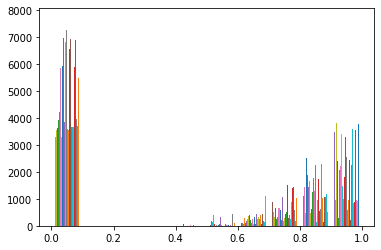

In [23]:
plt.hist(W)

https://stackoverflow.com/questions/29572623/plot-networkx-graph-from-adjacency-matrix-in-csv-file

그래프

링크의 방향성이 없는 네트워크 nx.Graph

In [ ]:
nx.draw(nx.Graph(W))
# 저장하고 싶으면
# plt.show(
# plt.savefig("networkGraph.png")

##### 5. $W_{i,j}$ 행렬을 이용한 차수 행렬 정의
- $D$ = Degree Matrix

In [24]:
D = np.diag(W.sum(axis=1))

In [25]:
D

array([[3106.24657496,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        , 1654.01767128,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        , 1371.12895284, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ..., 4543.00508374,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
        4798.2194415 ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , 4529.4440886 ]])

##### 6. Graph Laplacian matrix 정의
- $L = D - W$

In [26]:
L = D - W

In [27]:
L

array([[ 3.10524657e+03,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -8.22930703e-01,  0.00000000e+00],
       [ 0.00000000e+00,  1.65301767e+03, -7.85704634e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -7.85704634e-01,  1.37012895e+03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.54200508e+03, -8.78769584e-01, -9.99940088e-01],
       [-8.22930703e-01,  0.00000000e+00,  0.00000000e+00, ...,
        -8.78769584e-01,  4.79721944e+03, -8.74907815e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.99940088e-01, -8.74907815e-01,  4.52844409e+03]])

##### 7. 고유값 분해
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$
- $\Psi^\top \Psi = I$

In [28]:
λ, Ψ = np.linalg.eig(L)

In [29]:
Λ = np.diag(λ)

---

푸리에

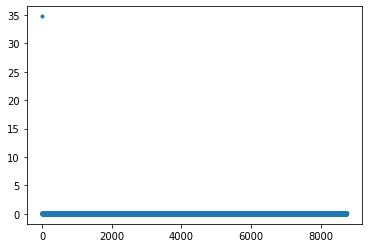

In [30]:
fbar = np.abs(np.fft.fft(f**2))/len(f)
plt.plot(fbar,'.')

In [31]:
fbar[0] 

34.77371866565151

In [32]:
len(f)/2

4372.0

In [ ]:
fbar2=np.zeros(10978)
#fbar2[0] = fbar[0] 
fbar2[0] = 0
fbar2[1:4372] = 2*fbar[1:4372]
plt.plot(fbar2,'.')

In [ ]:
fbar2[1:10]

---

##### 8. $ f \times \Psi \times \Psi^\top \times f \times \Psi \times \Psi^\top$
- $\mathcal{F}(f*g) = \mathcal{F}f \times \mathcal{F}g$
    - 유클리디안 도메인과 다른 비유클리디안 도메인, 이 이론은 비유클리디안에 적용되지 않음.
- $\hat{f} = \mathcal{F} f = \Psi^\top f = (<f,\psi_1>...,<f,\psi_n>)^\top$
- $f = \mathcal{F}^{-1} \hat{f} = \Psi \hat{f} = \psi_1 \hat{f}_1 + \dots + \psi_n \hat{f}_n$
- $f*g = \Psi((\Psi^\top f)⊙(\Psi^\top g))$

In [35]:
def p(i):
    return sum((f @ np.outer(Ψ[:,i], Ψ[:,i]))**2)

In [36]:
p_sum = np.array([p(i) for i in range(1,len(_df))])

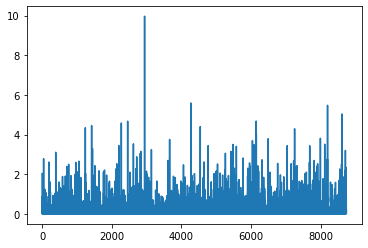

In [37]:
plt.plot(p_sum)

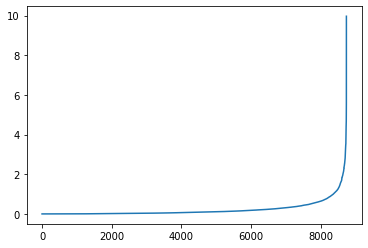

In [38]:
plt.plot(p_sum[np.argsort(p_sum)])

In [39]:
np.argsort(p_sum)[-10:-1]

array([1243, 4545, 1424, 2277, 2459, 6150, 8614, 8200, 4275])

In [40]:
p(375)

0.03294516107103258

In [41]:
sum(p_sum)

1945.7106515997737

In [42]:
(p(375)+p(722)+p(753)+p(333)+p(770))/sum(p_sum)

0.000103146997328279

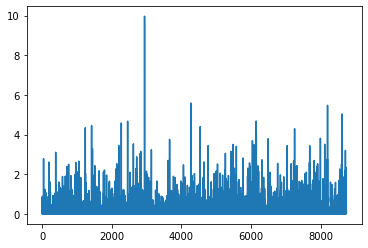

In [43]:
plt.plot(p_sum[1:])

(0.0, 40.0)

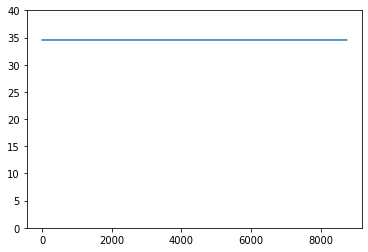

In [44]:
plt.plot( (f @ np.outer( Ψ[:,[0]], Ψ[:,[0]]))**2)
plt.ylim(0,40)

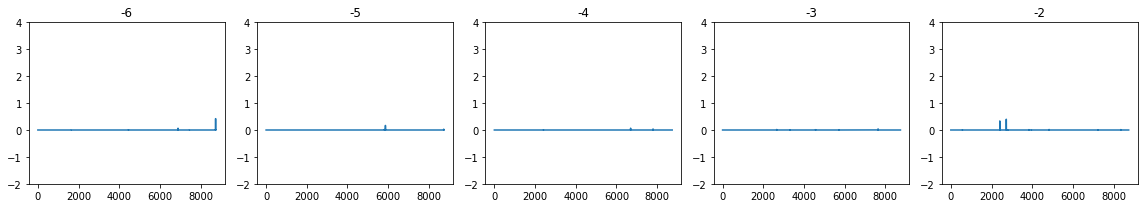

In [45]:
fig,ax =plt.subplots(1,5)
k=-6
for i in range(5):
    ax[i].plot((f @ np.outer( Ψ[:,np.argsort(p_sum)[k]], Ψ[:,np.argsort(p_sum)[k]]))**2)
    ax[i].set_ylim([-2,4])
    ax[i].set_title(k)
    k=k+1
fig.set_figwidth(16)            
fig.set_figheight(3)
fig.tight_layout()        

##### 9. PCA

In [46]:
comp1 = f @ np.outer( Ψ[:,[0]], Ψ[:,[0]])

In [49]:
___df = _df

In [50]:
___df["comp1"] = comp1

In [54]:
#collapse
_lst=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2016-2000)]

In [57]:
#collapse
__lst=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,4]].\
to_numpy().tolist() for i in range(2016-2000)]

In [58]:
_m=folium.Map(scrollWheelZoom=False)
plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2015,2000))).add_to(_m)
plugins.HeatMapWithTime(__lst,radius=5,index=list(range(2015,2000))).add_to(_m)
_m

ValueError: Input data and index are not of compatible lengths.

component 추정

In [59]:
np.argsort(p_sum)[-20:-1]

array([6090, 5484, 8119, 2624, 6043, 3664, 6497, 7995, 6155, 7254, 1243,
       4545, 1424, 2277, 2459, 6150, 8614, 8200, 4275])

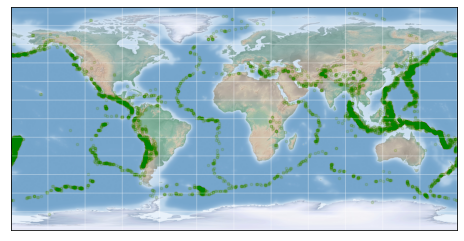

In [60]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 1
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.plot(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], 'r-', markersize=10)
m.scatter(x, y, color='orange', s=abs(f[0])*scale, alpha=abs(f[0])*0.01)
#m.scatter(x, y, color='violet', s=abs(f[np.argsort(p_sum)[-2]])*scale)
#m.scatter(x, y, color='purple', s=abs(f[np.argsort(p_sum)[-3]])*scale)
draw_map(m)

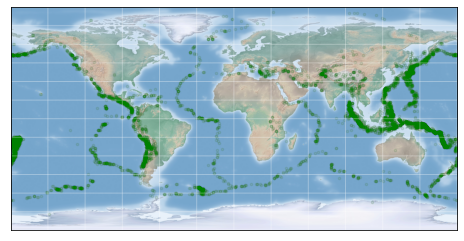

In [61]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 1
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.scatter(x, y, color='orange', s=abs(f[np.argsort(p_sum)[-1]])*scale)
m.scatter(x, y, color='violet', s=abs(f[np.argsort(p_sum)[-1]])*scale,alpha=abs(f[np.argsort(p_sum)[-1]])*0.01)
#m.scatter(x, y, color='purple', s=abs(f[np.argsort(p_sum)[-3]])*scale)
draw_map(m)

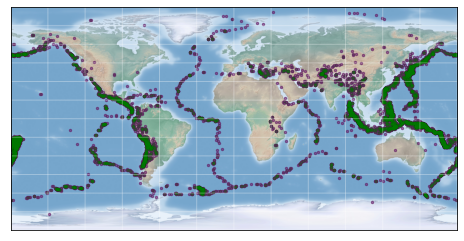

In [62]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 1
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.scatter(x, y, color='orange', s=abs(f[np.argsort(p_sum)[-1]])*scale)
#m.scatter(x, y, color='violet', s=abs(f[np.argsort(p_sum)[-2]])*scale)
m.scatter(x, y, color='purple', s=abs(f[np.argsort(p_sum)[-2]])*scale,alpha=abs(f[np.argsort(p_sum)[-2]])*0.1)
draw_map(m)

component1 빼고 component2 추정

---

ref: https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html